## Make tfrecords

In [1]:
import os
import glob
import json
import subprocess

import pandas as pd
import numpy as np
import librosa
import scipy.io.wavfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split

import tensorflow as tf
import tensorflow_io as tfio

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

main_dir = "Datasets\TIMIT-dataset\data"

In [2]:
# in_file = "Datasets\Youtube-audio-data\zWKBKKwyVrk.mp4"
# out_file = "zWKBKKwyVrk.ogg"

# subprocess.call([
#     "ffmpeg",
#     "-i",
#     in_file,
#     "-acodec",
#     "pcm_s16le",
#     "-ar",
#     "16000",
#     out_file
# ])

# subprocess.call([
#     "ffmpeg",
#     "-i",
#     in_file,
#     "-ar",
#     "40000",
#     out_file
# ])

# TODO: Include zero padding for audio and labels

In [26]:
frames = []
for sample in glob.glob("Datasets\TIMIT-dataset\data/*/*/*.wav"):
    y, sr = librosa.load(sample, sr=16000)
    frames.append(len(y))

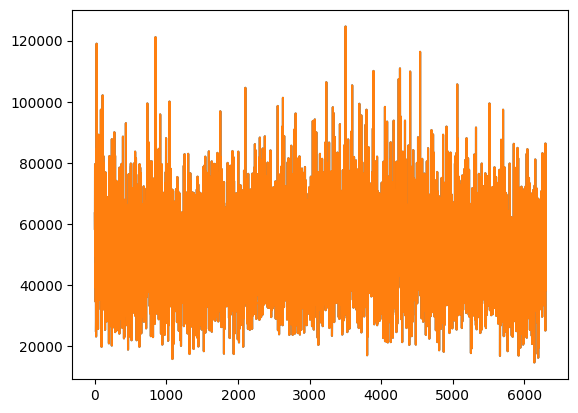

In [31]:
plt.plot(frames)
plt.show()

In [3]:
class TFRWriter():
    def __init__(self, main_dir, n_splits=5):
        self.main_dir = main_dir
        self.n_splits = n_splits
        self.phoneme_dict = self.get_dict()
        self.tfrec_writer()


    def shards(self):
        samples = glob.glob(self.main_dir + "/*/*/*.wav")
        speaker_id = [sample.split('\\')[4] for sample in samples]
        skf = StratifiedKFold(
            n_splits=self.n_splits, shuffle=True, random_state=42)
        return [
            list(map(lambda x: samples[x], j)) 
            for i, j in skf.split(samples, speaker_id)]


    def get_dict(self):
        samples = glob.glob(self.main_dir + "/*/*/*.wav")
        phonemes = set()
        for sample in samples:
            base_path = os.path.splitext(sample)[0]
            with open(base_path + '.phn', "r") as f:
                for line in f.readlines():
                    phonemes.add(line.split()[-1])
        phonemes = sorted(Counter(phonemes), key=Counter(phonemes).get, reverse=True)
        phonemes_dict = {v: i for i, v in enumerate(phonemes)}
        with open("Datasets\TIMIT-dataset\phoneme_dict.json", "w") as f:
            json.dump(phonemes_dict, f, sort_keys=False, indent=4)
        return phonemes_dict


    def get_labels(self, p_frames, phonemes):
        labels = []
        for i in range(1, len(p_frames)):
            for j in range(p_frames[i-1], p_frames[i]):
                labels.append(phonemes[i-1])
        labels = list(map(self.phoneme_dict.get, labels))
        labels = tf.convert_to_tensor(labels)
        return tf.io.serialize_tensor(labels)


    def get_shard_data(self, samples):
        for sample in tqdm(samples, total=len(samples)):
            base_path = os.path.splitext(sample)[0]
            p_frames, phonemes = [0], []
            with open(base_path + ".phn") as f:
                for line in f.readlines():
                    p_frame, phoneme = line.split()[1::]
                    p_frames.append(int(p_frame))
                    phonemes.append(str(phoneme))
            audio = tf.io.read_file(sample)
            labels = self.get_labels(p_frames, phonemes)
            filename = str.encode("/".join(sample.split('\\')[-3::]))
            yield {
                "audio": audio,
                "labels": labels,
                "filename": filename}


    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


    def _float_feature(self, value):
        """Returns a float_list from a float / double."""
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


    def serialize_example(self, *args):
        feature = {
            'audio': self._bytes_feature(args[0]),
            'labels': self._bytes_feature(args[1]),
            'filename': self._bytes_feature(args[2])}

        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()


    def tfrec_writer(self):
        for shard, samples in enumerate(self.shards()):
            with tf.io.TFRecordWriter(f"Datasets/TIMIT-dataset/tfrec_data/train_{shard}.tfrec") as f:
                for sample in self.get_shard_data(samples):
                    example = self.serialize_example(
                        sample['audio'], sample['labels'], sample['filename'])
                    f.write(example)

# TFRWriter(main_dir)

## Load from tfrecords

In [4]:
def read_tfrecord(example):
    feature_description = {
        'audio': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([], tf.string),
        'filename': tf.io.FixedLenFeature([], tf.string)}
    
    example = tf.io.parse_single_example(example, feature_description)
    example['audio'] = tf.audio.decode_wav(example['audio'])[0]
    example['labels'] = tf.io.parse_tensor(example['labels'].numpy(), out_type=tf.int32)
    return example

raw_dataset = tf.data.TFRecordDataset(r"Datasets/TIMIT-dataset/tfrec_data/train_0.tfrec")

for raw_record in raw_dataset.take(1):
    example = read_tfrecord(raw_record)
    print(example)

{'audio': <tf.Tensor: shape=(58061, 1), dtype=float32, numpy=
array([[ 6.1035156e-05],
       [ 1.8310547e-04],
       [ 9.1552734e-05],
       ...,
       [-3.0517578e-05],
       [ 1.8310547e-04],
       [-6.1035156e-05]], dtype=float32)>, 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'DR1/FAKS0/SA2.wav'>, 'labels': <tf.Tensor: shape=(58000,), dtype=int32, numpy=array([21, 21, 21, ..., 21, 21, 21])>}


In [21]:
class TIMITDataset():
    def __init__(self, main_dir):
        self.files = [os.path.join(main_dir, f) for f in os.listdir(main_dir)]
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.BUFFER_SIZE = 1024
        self.BATCH_SIZE = 8
        self.train_files, self.test_files = train_test_split(
            self.files, test_size=0.2, shuffle=True)

    def decode_audio(self, audio):
        audio = tf.audio.decode_wav(audio)[0]
        return tf.squeeze(audio, axis=-1)

    def read_tfrecord(self, example):
        feature_description = {
            'audio': tf.io.FixedLenFeature([], tf.string),
            'labels': tf.io.FixedLenFeature([], tf.string),
            'filename': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['audio'] = self.decode_audio(example['audio'])
        example['labels'] = tf.io.parse_tensor(example['labels'], out_type=tf.int32)
        return example


    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(
            partial(self.read_tfrecord), 
            num_parallel_calls=self.AUTOTUNE)
        return dataset


    def get_spectrogram(self, sample):
        waveform = sample['audio']
        zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
        spectrogram = tf.abs(tfio.audio.spectrogram(
            waveform, nfft=512, window=512, stride=256))
        mel_spectrogram = tfio.audio.melscale(
            spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
        waveform = mel_spectrogram
        return sample


    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.map(partial(self.get_spectrogram), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(self.BUFFER_SIZE)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset


    def test(self):
        dataset = self.load_dataset(self.test_files)
        dataset = dataset.map(
            partial(self.get_spectrogram), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.shuffle(self.BUFFER_SIZE)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

main_dir = "Datasets/TIMIT-dataset/tfrec_data"
dataset = TIMITDataset(main_dir).train()
dataset

Tensor("zeros:0", shape=(None,), dtype=float32)


<PrefetchDataset shapes: {audio: (None, None), filename: (None,), labels: <unknown>}, types: {audio: tf.float32, filename: tf.string, labels: tf.int32}>

In [15]:
next(iter(dataset))

InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [174,128] and element 1 had shape [192,128]. [Op:IteratorGetNext]